## Self-Taught Learning

#### I : 
Load Task3C_labeled.csv, Task3C_unlabeled.csv and Task3C_test.csv data.

In [1]:
#importing libraries and closing the warnings
options(warn=-1)   
library(h2o)        
library(ggplot2)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



In [2]:
#calculate error rate
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

In [3]:
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)

# Use the "absolute" path to the datasets on machine
labeled.frame <- h2o.importFile(path = 'C:/Users/Qixuan/Desktop/5201A2/assessments_datasets/Task3C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'C:/Users/Qixuan/Desktop/5201A2/assessments_datasets/Task3C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'C:/Users/Qixuan/Desktop/5201A2/assessments_datasets/Task3C_test.csv' ,sep=',') 


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\Qixuan\AppData\Local\Temp\RtmpARikUE/h2o_Qixuan_started_from_r.out
    C:\Users\Qixuan\AppData\Local\Temp\RtmpARikUE/h2o_Qixuan_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 seconds 339 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.18.0.8 
    H2O cluster version age:    23 days  
    H2O cluster name:           H2O_started_from_R_Qixuan_dml018 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   6.00 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
 

In [4]:
#remove NA in unlabeled dataset
unlabeled.frame<- na.omit(unlabeled.frame)

#combining labeled dataframe and unlabeled dataframe
train.frame <- h2o.rbind(labeled.frame, unlabeled.frame)

#change labels to factor format
labeled.frame[,1] <- as.factor(labeled.frame$label)
test.frame[,1] <- as.factor(test.frame$label)

In [5]:
#build reconstruction and classification error matrix for training and test dataset
reconstruction.train.error <- matrix(NA, nrow=25, ncol=1)
classification.labeled.error <- matrix(NA, nrow=25, ncol=1)
reconstruction.test.error <- matrix(NA, nrow=25, ncol=1)
classification.test.error <- matrix(NA, nrow=25, ncol=1)

#### II & III & V: 

In [6]:
#build a function for building encoder models
model_func <- function(x){
  nn.model=h2o.deeplearning(      #call function 
  x = 1:ncol(train.frame),        # select all pixels + extra features
  training_frame = train.frame,   # specify the frame (labeled+unlabeled)    
  hidden = c(x),                  # number of layers and their units
  epochs = 50,                    # maximum number of epoches  
  activation = 'Tanh',            # activation function 
  autoencoder = TRUE,             # is it an autoencoder? Yes!
  l2 = 0.1                        # specify the L2 regularisation weight to add stability
)
  return(nn.model)
}

In [7]:
#training model with original data + extra feature
model_func2 <- function(df){  
  nn.model=h2o.deeplearning(       # build a NN classifier based on the labeled training data
  x = 2:ncol(df),                  # select all pixels + extra features
  y = 1,                           # specify training label
  training_frame = df,             # specify the frame (imported file)    
  hidden = c(100),                 # number of layers and their units
  epochs = 50,                     # maximum number of epoches  
  activation = 'Tanh',             # activation function 
  autoencoder = FALSE,             # is it an autoencoder? No!
  l2 = 0.1                         # specify the L2 regularisation weight to add stability
)
  return(nn.model)
}

In [11]:
i=1
for (k in seq(20, 500, 20)){ # for different neurons in the hidden layer seq(20,80,20)
  
  #### Q3.2 & Q3.3:
  ## Train an autoencoder with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, .., 500
  ## Calculate and record the reconstruction error
    
  model<-model_func(k)    #build a autoencoder model
  mse<-h2o.anomaly(model,train.frame)    #calculate MSE for each images 
  reconstruction.train.error[i]<-mean(mse) #calculate the average of MSE 

  #### Q3.5
  ## A. Add the output of the middle layer as extra features to the original feature set,
  ## B. Train a 3-layer NN (similar to Step IV) using all features (original + extra). Then calculate and record the test error.

  project<- h2o.deepfeatures(model, labeled.frame[,-1], layer=1)    # extract the middle layer as extra features
  project<- as.h2o(project)                                         #format the features table
  cancat.df<-h2o.cbind(labeled.frame, project)                      #combine original data and new features
  labeled.predict <- h2o.predict(model_func2(cancat.df), test.frame)$predict     #predict labels
  classification.test.error[i]<-error.rate(test.frame$label, labeled.predict)    #calculate errors
  i<-i+1
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [12]:
#show reconstrction errors
reconstruction.train.error

0.030183028
0.014946623
0.010282409
0.008430945
0.008840729
0.007460532
0.007786399
0.008503481
0.007588918
0.007692004
0.008485839


In [13]:
#show classification errors
classification.test.error

0.539
0.515
0.603
0.605
0.584
0.626
0.545
0.585
0.565
0.561
0.364


### IV:
Use the 3-layer NN or “h2o.deeplearning” function to build a model with 100 units in the hidden layer using
all the original attributes from the training set. Then, calculate and record the test
error.

In [14]:
# build a neural network classifier based on the labeled training data
NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame),      # select all pixels + extra features
  y = 1,                          # specify training label
  training_frame = labeled.frame, # specify the frame (using labeled data required from Q1)    
  hidden = c(100),                # number of layers and their units
  epochs = 50,                    # maximum number of epoches  
  activation = 'Tanh',            # activation function 
  autoencoder = FALSE,            # is it an autoencoder? No!
  l2 = 0.1                        # specify the L2 regularisation weight to add stability
)

  |======================================================================| 100%


In [15]:
#predict the label and calculate the error
labeled.predict <- h2o.predict(NN.model, test.frame)$predict
q4.error<-error.rate(test.frame$label, labeled.predict)
q4.error

  |======================================================================| 100%


[1] 0.55

In [16]:
# Produce the needed plots.
#set K
K.data<-seq(20,500,20)
G.data<-K.data+ncol(labeled.frame)
#build a data frame for error
reconst.error<-data.frame(cbind(rep(K.data, 1, each=1),reconstruction.train.error))
misclust.error<-data.frame(cbind(rep(G.data, 1, each=1),classification.test.error))

#give it a column name
names(reconst.error)<-c('Number_of_neurons','Error_rate')
names(misclust.error)<-c('Number_of_features','Error_rate')


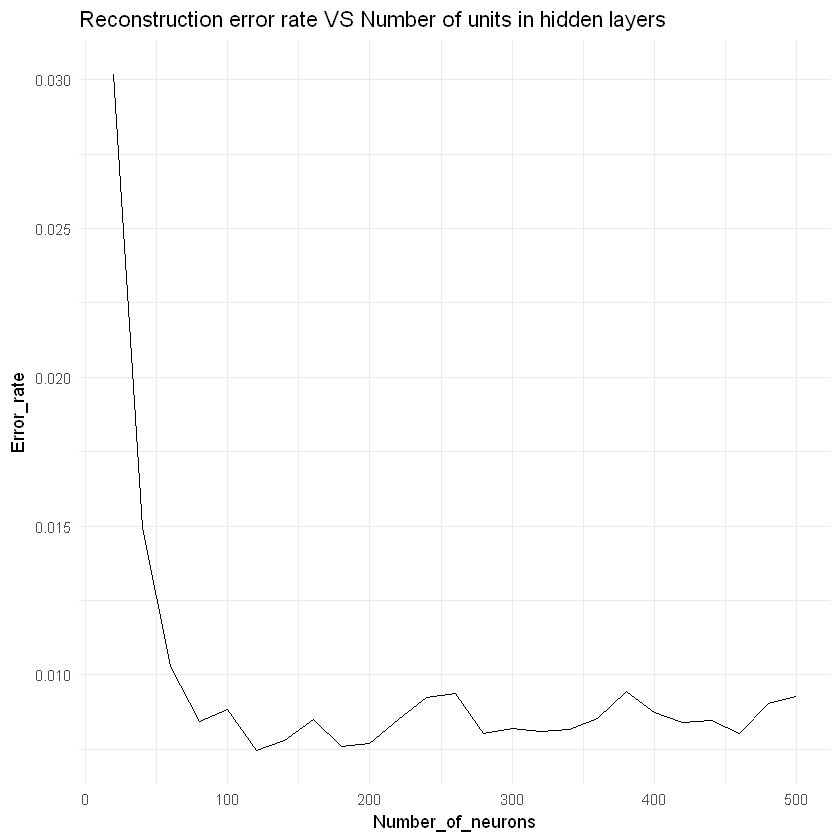

In [17]:
#plotting 
ggplot(data=reconst.error, aes(x=Number_of_neurons, y=Error_rate)) +
  geom_line() +
  labs(title='Reconstruction error rate VS Number of units in hidden layers') +  
  theme_minimal()

##### explain findings based on the plot:
With the number of units in the hidden layer increasing, the reconstruction error is decreasing. It has a dramatic decrease until the number of units up to 100. After that, the average error rate is around 0.9% as the number of units increasing.

#### VI
Plot the error rates for the 3-layer neural networks from Step IV and V while the
x-axis is the number of features and y-axis is the classification error.

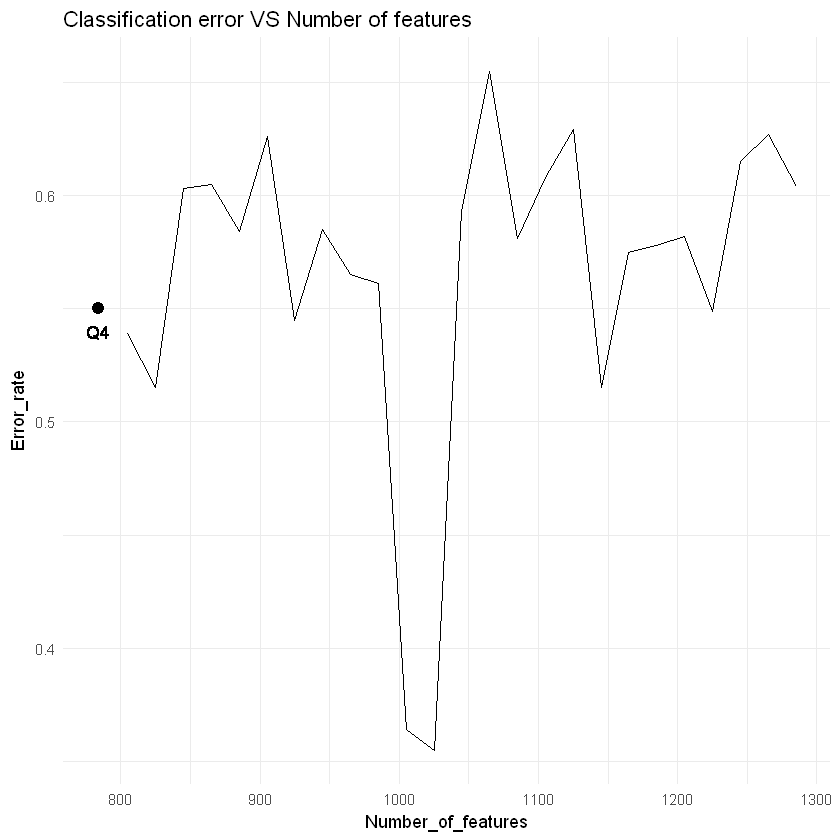

In [18]:
#plotting classfication errors
ggplot(data=misclust.error, aes(x=Number_of_features, y=Error_rate),label="Q4") +
  geom_line() +
  geom_point(aes(x=ncol(train.frame)-1, y=q4.error), size=3) +
  geom_text(aes(x=ncol(train.frame)-1, y=q4.error-0.01, label="Q4"))+
  labs(title='Classification error VS Number of features') +  
  theme_minimal()

### VII:
Report the optimum number(s) of units in the middle layer of the autoencoder in
terms of the reconstruction and misclassification errors

Because the misclassfication error hebavior is undisireable (It may caused by small training data set or model overfitting). We can just infer the optimum units from the reconstruction error plot. I think the optimal units should be 100. Because the error has a dramatic decrease until the number of units up to 100. And then, the average error tends to be gentle. Also, the performance difference does not have any changes when the hidden layers increasing start from 100. So we could eliminate unnecessary and redundant nodes and take 100 as our optimum units.

### VIII:
Comparing the plot from Step III and VI, do you observe any relation between
the reconstruction error and misclassification error? Explain your finding in your Notebook
file.

From the plots above, there is less relation between the reconstruction error and misclassfication error because there is too small training data set as well as too large test set to make the misclassfication errors behaviour abnormal. We can see the errors are all around 60%, and the error around 30% is a occasional event. But in fact, if we have optimal enough training set, we might see that with the increasing of number of features or with the increasing number of neurons, the errors would be decreasing. However, there should be a point where can keep the error around (in our 3 layer case, it is 100). Also, with the increasing number of features, the error would be increase after a specific number of features because too many parameters would make the model overfitting.  